## Data Augmentation with Augmix

In [1]:
from PIL import Image, ImageOps, ImageEnhance
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms

---

## Calculate, MEAN and STD

In [2]:
train_dataset_path = '/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/'

train_transforms = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
 ])

train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [3]:
def get_mean_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        images_count_in_batch = images.size(0)
        images = images.view(images_count_in_batch, images.size(1), -1)
        mean+= images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count_in_batch
    mean /= total_images_count
    std /= total_images_count

    return mean,std

In [4]:
get_mean_std(train_loader)

(tensor([0.5642, 0.5642, 0.5642]), tensor([0.2102, 0.2102, 0.2102]))

In [6]:
MEAN = [0.5642, 0.5642, 0.5642]
STD = [0.2361, 0.2361, 0.2361]

In [ ]:
#(tensor([0.5642, 0.5642, 0.5642]), tensor([0.2361, 0.2361, 0.2361]))


# train_transforms = transforms.Compose([
#     transforms.Resize((300,300)),
#     # transforms.RandomHorizontalFlip(),
#     # transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
#  ])

# train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform=train_transforms)

# from sklearn.utils import shuffle


# def showimg(dataset):
#     loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
#     batch = next(iter(loader))
#     images, labels = batch

#     grid = torchvision.utils.make_grid(images, nrow = 3)
#     plt.figure(figsize=(11,11))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     print('labels: ', labels)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

---

## Random Augmix


In [7]:
# ImageNet code should change this value
IMAGE_SIZE = 300
HEIGHT = 300
WIDTH = 300

### Augmix functions

In [8]:
def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)




augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

In [9]:
def normalize(image):
  """Normalize input image channel-wise to zero mean and unit variance."""
  image = image.transpose(2, 0, 1)  # Switch to channel-first
  mean, std = np.array(MEAN), np.array(STD)
  image = (image - mean[:, None, None]) / std[:, None, None]
  return image.transpose(1, 2, 0)


In [10]:
def apply_op(image, op, severity):
  image = np.clip(image * 255., 0, 255).astype(np.uint8)
  pil_img = Image.fromarray(image)  # Convert to PIL.Image
  pil_img = op(pil_img, severity)
  return np.asarray(pil_img) / 255.

In [12]:
def augment_and_mix(image, severity=1, width=3, depth=1, alpha=1.):

  augmentations = [equalize, posterize, solarize, shear_x, shear_y,
    translate_x, translate_y]

  """Perform AugMix augmentations and compute mixture.
  Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
  Returns:
    mixed: Augmented and mixed image.
  """
  ws = np.float32(
      np.random.dirichlet([alpha] * width))
  m = np.float32(np.random.beta(alpha, alpha))

  mix = np.zeros_like(image)
  for i in range(width):
    image_aug = image.copy()
    d = depth if depth > 0 else np.random.randint(1, 4)
    for _ in range(d):
      op = np.random.choice(augmentations)
      image_aug = apply_op(image_aug, op, severity)
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * normalize(image_aug)

  mixed = (1 - m) * normalize(image) + m * mix
  return mixed

### Sampling Images

In [13]:
DEFECT = "/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/def_front/"
OKAY = "/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/ok_front/"

In [14]:
data = []
data.append(os.listdir(DEFECT)[75])
data.append(os.listdir(DEFECT)[-45])
data.append(os.listdir(OKAY)[100])
data.append(os.listdir(OKAY)[-50])

['cast_def_0_2641.jpeg',
 'cast_def_0_7704.jpeg',
 'cast_ok_0_8036.jpeg',
 'cast_ok_0_8062.jpeg']

In [15]:
def visualize(original_image,aug_image):
    fontsize = 10
    plt.axis("off")
    plt.style.use('dark_background')
    
    f, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(original_image)
    plt.axis("off")
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image)
    ax[1].set_title('Augmented image', fontsize=fontsize)
    plt.axis("off")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:81: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  Image.AFFINE, (1, 0, level, 0, 1, 0),
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:82: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resample=Image.BILINEAR)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:63: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  Image.AFFINE, (1, level, 0, 0, 1, 0),
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:64: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resamp

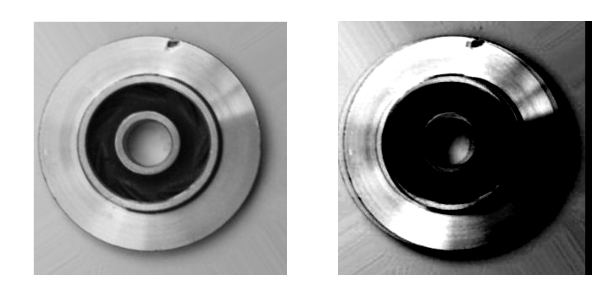

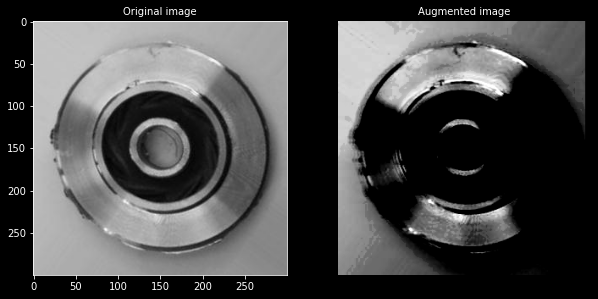

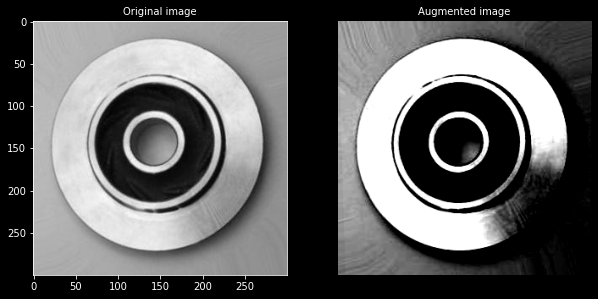

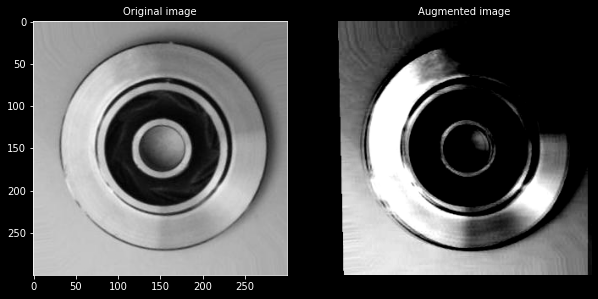

In [16]:
for file_name in data:
    if "def" in file_name:
        img = cv2.imread(DEFECT +file_name)
    else:
        img = cv2.imread(OKAY +file_name)
    img = img.astype("float32") / 255.0
    img_aug = augment_and_mix(img)

    plt.style.use('dark_background')
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img)
    ax[0].set_title('Original image', fontsize=10)
    ax[1].imshow(img_aug)
    ax[1].set_title('Augmented image', fontsize=10)
    plt.axis("off")

# plt.show

---

## Modeling

### Import data

In [17]:
def_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/def_front/*.*')
ok_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/ok_front/*.*')

In [18]:
data = []
labels = []

In [19]:
for count, i  in enumerate(def_front):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (28,28))
    image=np.array(image)
    image = image.astype("float32") / 255.0
    data.append(image)
    labels.append(0)

for i in ok_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (28,28))
    image=np.array(image)
    image = image.astype("float32") / 255.0
    data.append(image)
    labels.append(1)


In [20]:
# data = np.array(data)
labels = np.array(labels, dtype=np.uint8)

## Split Data

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### Apply Augmix

In [23]:
IMAGE_SIZE = 28
x_train_augmix = []
for elements in x_train:
    img_aug = augment_and_mix(elements)
    x_train_augmix.append(img_aug)


/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:72: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  Image.AFFINE, (1, 0, 0, level, 1, 0),
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:73: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resample=Image.BILINEAR)
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:90: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  Image.AFFINE, (1, 0, 0, 0, 1, level),
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8007/355285211.py:91: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resample=Image.BILINEAR)
/var/folders/9r/h3vgqf_57bbdqxz309j91nkw0000gn/T/ipykernel_8

In [24]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 15

In [25]:
# x_train = x_train.astype("float32") / 255.0
x_train_augmix = np.reshape(x_train_augmix, (-1, 28, 28, 3))
x_train = np.reshape(x_train, (-1, 28, 28, 3))
y_train = tf.one_hot(y_train, 2)

# x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 3))
y_test = tf.one_hot(y_test, 2)

2022-07-16 07:11:22.204747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
train_augmix_ds = tf.data.Dataset.from_tensor_slices((x_train_augmix, y_train)).batch(BATCH_SIZE)

In [27]:
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Build Model

In [28]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 3)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(2, activation="softmax"), # Change softmax / sigmoid
        ]
    )
    return model

In [29]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights_augmix_28x28.h5")

In [30]:
model_augmix = get_training_model()
model_augmix.load_weights("initial_weights_augmix_28x28.h5")
model_augmix.compile(
    loss="categorical_crossentropy", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam", metrics=["accuracy"]) # categorical_crossentropy / binary_crossentropy / sparse_categorical_crossentropy
model_augmix.fit(train_augmix_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
166/166 [==============================] - 4s 20ms/step - loss: 0.5296 - accuracy: 0.7252 - val_loss: 6.0493 - val_accuracy: 0.4137
Epoch 2/15
166/166 [==============================] - 3s 17ms/step - loss: 0.3667 - accuracy: 0.8383 - val_loss: 8.3398 - val_accuracy: 0.4137
Epoch 3/15
166/166 [==============================] - 3s 17ms/step - loss: 0.3283 - accuracy: 0.8545 - val_loss: 9.8197 - val_accuracy: 0.4137
Epoch 4/15
166/166 [==============================] - 3s 17ms/step - loss: 0.3021 - accuracy: 0.8685 - val_loss: 10.5911 - val_accuracy: 0.4137
Epoch 5/15
166/166 [==============================] - 3s 18ms/step - loss: 0.2736 - accuracy: 0.8816 - val_loss: 11.1032 - val_accuracy: 0.4137
Epoch 6/15
166/166 [==============================] - 3s 16ms/step - loss: 0.2592 - accuracy: 0.8896 - val_loss: 11.6346 - val_accuracy: 0.4137
Epoch 7/15
166/166 [==============================] - 3s 17ms/step - loss: 0.2518 - accuracy: 0.8933 - val_loss: 11.2019 - val_accuracy: 0.

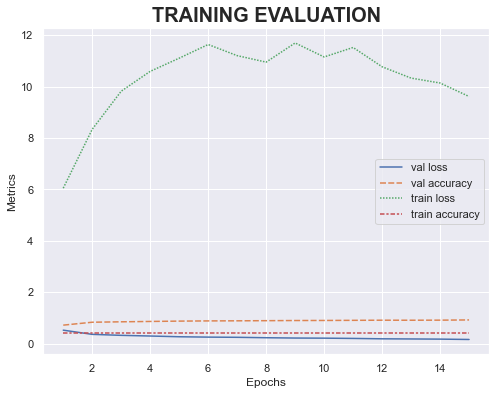

In [31]:
import seaborn as sns
sns.set()

plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_augmix.history.history,
                                 index = range(1, 1+len(model_augmix.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

## Accuracy on test data

In [32]:
def_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/def_front/*.*')
ok_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/ok_front/*.*')

data_test = []
labels_test = []

for i in def_front_test:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (28,28))
    image=np.array(image)
    data_test.append(image)
    labels_test.append(0)

for i in ok_front_test:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (28,28))
    image=np.array(image)
    data_test.append(image)
    labels_test.append(1)

data_test = np.array(data_test)
labels_test = np.array(labels_test, dtype=np.uint8)

data_test = data_test.astype("float32") / 255.0
data_test = np.reshape(data_test, (-1, 28, 28, 3))
labels_test = tf.one_hot(labels_test, 2)


test_ds = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(32)

In [33]:
_, test_acc = model_augmix.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

23/23 [==============================] - 0s 6ms/step - loss: 10.3622 - accuracy: 0.3664
Test accuracy: 36.64%


In [34]:
model_augmix.save('augmix')

INFO:tensorflow:Assets written to: augmix/assets


INFO:tensorflow:Assets written to: augmix/assets


## Sample Predictions

In [37]:
model_augmix_loaded = tf.keras.models.load_model("augmix")

In [38]:
image=tf.keras.preprocessing.image.load_img("/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/def_front/cast_def_0_242.jpeg", color_mode='rgb', target_size= (28,28))
image=np.array(image)
image = image.astype("float32") / 255.0
image = np.reshape(image, (-1, 28, 28, 3))

pred = model_augmix_loaded.predict(image)
pred

1/1 [==============================] - 0s 126ms/step


array([[1.0089877e-07, 9.9999988e-01]], dtype=float32)

In [39]:
image=tf.keras.preprocessing.image.load_img("/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/ok_front/cast_ok_0_246.jpeg", color_mode='rgb', target_size= (28,28))
image=np.array(image)
image = image.astype("float32") / 255.0
image = np.reshape(image, (-1, 28, 28, 3))
pred = model_augmix_loaded.predict(image)
pred

1/1 [==============================] - 0s 24ms/step


array([[4.9647234e-08, 1.0000000e+00]], dtype=float32)